In [277]:
import numpy as np
from qiskit import *
from qiskit.qobj.utils import MeasLevel
from qiskit_experiments.framework import ParallelExperiment, BatchExperiment, BaseExperiment
from qiskit_experiments.library import T1
from qiskit_experiments.library.characterization.analysis.t1_analysis import T1KerneledAnalysis
# A T1 simulator
from qiskit.providers.fake_provider import FakePerth
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, ReadoutError, RelaxationNoisePass, reset_error
from qiskit.transpiler import InstructionProperties, PassManager, Target, TransformationPass
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy as sp
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Computer Modern']

# T1 characterization
> [Reference: Qiskit Experiments documentation](https://qiskit.org/ecosystem/experiments/manuals/characterization/t1.html#t1-characterization)
## Introduction
$T_1$ is termed the decoherence time.  
Experiment is carried out by repeatedly measuring an excited qubit $\ket{1}$.  
Define the delay between excitation of the qubit and instance of the measurement as $t$.  
In an ideal setting, the expectation value of the measurement depends on the delay as $\exp(-t/T_1)$.  
$$
\bra{1}\hat{\sigma}_z \: \hat{D}(t)\ket{1}
$$
However, in the presence of measurement errors and state preparation, 
During the delay period, inhomogeneity in the magnetic field could slowly bring the Bloch vector towards the $X-Y$ plane.
As the projection onto the $Z$ axis decays, the expectation value assumes the form $A\exp(-t/T_1) + B$.  
The goal is to simulate this experiment and estimate the values of $A$,$T_1$, and $B$

## Sample code

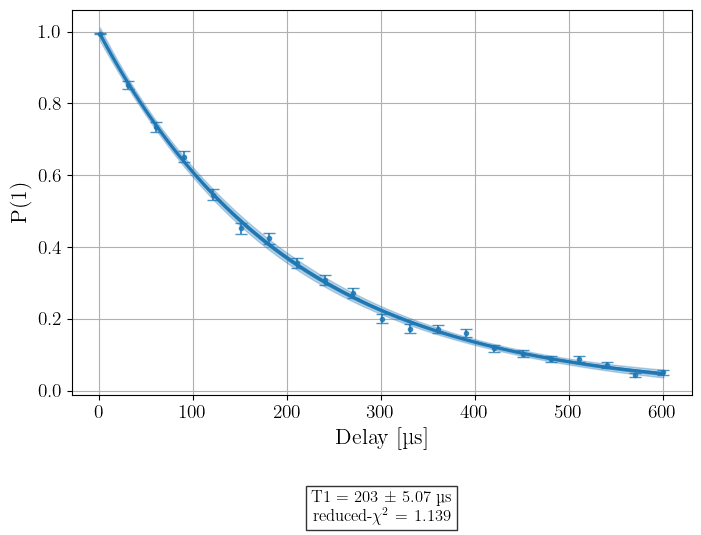

AnalysisResult
- name: @Parameters_T1Analysis
- value: CurveFitResult:
 - fitting method: least_squares
 - number of sub-models: 1
  * F_exp_decay(x) = amp * exp(-x/tau) + base
 - success: True
 - number of function evals: 16
 - degree of freedom: 18
 - chi-square: 20.508278687616514
 - reduced chi-square: 1.1393488159786953
 - Akaike info crit.: 5.502430311729853
 - Bayesian info crit.: 8.635997624900122
 - init params:
  * amp = 0.9512195121951219
  * tau = 0.00019768173260363767
  * base = 0.04341463414634146
 - fit params:
  * amp = 1.0032536321972947 ± 0.007783268403178043
  * tau = 0.00020330086618393497 ± 5.0701304126008315e-06
  * base = -0.004960633605629515 ± 0.007030360126872607
 - correlations:
  * (tau, base) = -0.901852027776264
  * (amp, base) = -0.6626354666405426
  * (amp, tau) = 0.4443652863760459
- quality: good
- device_components: ['Q0']
- verified: False
AnalysisResult
- name: T1
- value: 0.000203+/-0.000005
- χ²: 1.1393488159786953
- quality: good
- extra: <1 ite

In [229]:


# Create a pure relaxation noise model for AerSimulator
noise_model = NoiseModel.from_backend(
    FakePerth(), thermal_relaxation=True, gate_error=False, readout_error=False
)

# Create a fake backend simulator
backend = AerSimulator.from_backend(FakePerth(), noise_model=noise_model)

# Look up target T1 of qubit-0 from device properties
qubit0_t1 = FakePerth().qubit_properties(0).t1

# Time intervals to wait before measurement
delays = np.arange(1e-6, 3 * qubit0_t1, 3e-5)
# Create an experiment for qubit 0
# with the specified time intervals
exp = T1(physical_qubits=(0,), delays=delays)

# Set scheduling method so circuit is scheduled for delay noise simulation
exp.set_transpile_options(scheduling_method='asap')

# Run the experiment circuits and analyze the result
exp_data = exp.run(backend=backend, seed_simulator=101).block_for_results()

# Print the result
display(exp_data.figure(0))
for result in exp_data.analysis_results():
    print(result)

### packages imported
1. `numpy`
2. `qiskit.qobj.utils.MeasLevel`
3. `qiskit_experiments.library`
    1. `framework.ParallelExperiment`
    2. `library.T1`
    3. `library.characterization.analysis.t1_analysis.T1KerneledAnalysis`
4. `qiskit.providers.fake_provider.FakePerth`
5. `qiskit_aer.AerSimulator`
6. `qiskit_aer.noise.NoiseModel`
7. 
## Code study and terminology review#
The task is to build and execute a quantum circuit.  
Instead of using an actual quantum computer, one may use a *simulator*.
1. Preparation
```
noise_model = NoiseModel.from_backend(
    FakePerth(), thermal_relaxation=True, gate_error=False, readout_error=False
)
```
* `backend = AerSimulator.from_backend(FakePerth(), noise_model=noise_model)`    
    The backend (provided by the *Aer provider*) handles simulation of an ideal quantum computer.  
    `FakePerth()` is a backend provider (*fake provider*) that mimics the behavior of an actual quantum computer.  
    The `noise_model` provided by `FakePerth()` is implemented in the instanced Aer simulator backend.
    `FakePerth().qubit_properties(0)` retrieves the attributes of `FakePerth()`, that is "qubit 0".  
    Here the attributes of interest is the decoherence time `.t1`.
    The decoherence time of qubit 0 `qubit0_t1` is roughly $200 \mu s$ 

2. Experiment setup 
* `delays = np.arange(1e-6, 3 * qubit0_t1, 3e-5)`
    In this simulation, the delay time ranges from $1 \mu s$ to threefold decoherence time, in $30 \mu s$ increments.
    Sampling occurrs every $30 \mu s$, totaling to 21 points.
  
3. Execution
* `exp = T1(physical_qubits=(0,), delays=delays)`
    The quantum circuit to be simulated is contained in the `T1` class object 
    Measurements repeat 1024 times (documentation default `shots` count)
    Experiment carries out multiple measurements at each delay time.

4. Results and visualization  
    The plot shows the fitted curve, parameterized as $A\exp(-t/\tau)+B$.
    A confidence band of the fitted curve is also included, as well as the error bar at each delay time measurements.

5. Miscellaneous
    * `.block_for_results()` tells the program to wait until all pending jobs and analysis callbacks finish.

1 µs delay circuit


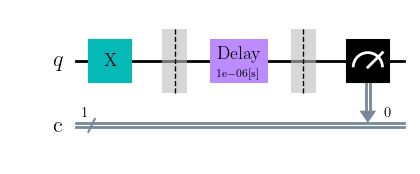

In [154]:
#for i in exp.circuits():
#    print(i)
# The attribute `.circuits()` of class T1 is a list of QuantumCircuits
# One quantum circuit for each delay time
print("1 µs delay circuit")
exp.circuits()[0].draw(output='mpl',style='clifford')

## Self implementation of the T1 experiment

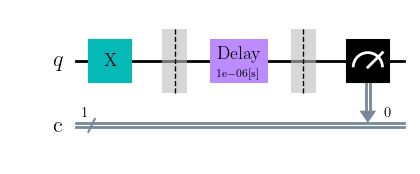

In [155]:
us = 1E-6
time = 1*us
T1_circ = QuantumCircuit(1,1)
T1_circ.x(0)
T1_circ.barrier()
T1_circ.delay(duration=time,qarg=0,unit='s')
T1_circ.barrier()
T1_circ.measure(qubit=0,cbit=0)
T1_circ.draw(output='mpl',style='clifford')

In [158]:
shots = 1024
# Parameterize the quantum circuits 
def T1_delay(time):
    T1_circ = QuantumCircuit(1,1)
    T1_circ.x(0)
    T1_circ.barrier()
    T1_circ.delay(duration=time,qarg=0,unit='s')
    T1_circ.barrier()
    T1_circ.measure(qubit=0,cbit=0)
    return T1_circ
trials = 1024
T1_results = np.zeros(shape=(len(delays),trials))
# using the same set of delay times "delays"
for i,t in enumerate(delays):
    # using the same Aer backend
    for j in range(trials):
        T1_exe = backend.run(transpile(T1_delay(t),backend=backend))
        T1_results[i,j] = T1_exe.result().get_counts()['1']/shots

In [164]:
#np.save("T1_results_512",T1_results)
#np.save("T1_results_1024",T1_results)
T1_results = np.load("T1_results_1024.npy")
T1_results.shape

(21, 1024)

In [417]:
T1_results = np.load("T1_results_1024.npy")
delays = np.arange(1e-6, 3 * qubit0_t1, 3e-5)
def T1_prob(x,A,T,B):
    return A*np.exp(-1*x/T)+B
T1_mean = np.mean(T1_results,axis=1)
T1_std = np.std(T1_results,axis=1)
opt_param, param_cov = sp.optimize.curve_fit(T1_prob,delays/us,T1_mean,bounds=([0.8,100,-0.2],[1.2,300,0.2]))
print("Optimal parameters: {:.2f}exp(-t/{:.2f})+{:.2f}".format(opt_param[0],opt_param[1],opt_param[2]))
A = opt_param[0]
T = opt_param[1]
B = opt_param[2]

Optimal parameters: 1.00exp(-t/200.87)+-0.00


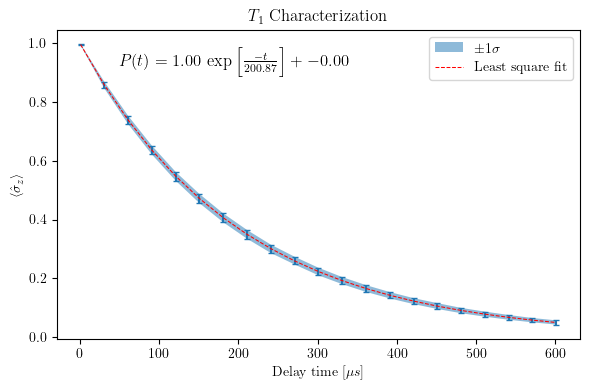

In [233]:
fig = plt.figure(figsize=(6,4))
plt.errorbar(x=delays/us,y=T1_mean,yerr=T1_std,capsize=2,ls='None')
plt.fill_between(delays/us,T1_mean+T1_std,T1_mean-T1_std,alpha=0.5,label=r'$\pm 1\sigma$')
plt.ticklabel_format(axis='x',style='sci',useMathText=True,scilimits=(-3,3))
plt.ylabel(r"$\langle \hat{\sigma}_z \rangle$")
plt.xlabel(r"Delay time $[\mu s]$")
plt.title(r"$T_1$ Characterization")
plt.plot(delays/us,T1_prob(delays/us,A,T,B),ls='dashed',c='r',lw=0.75,\
         label='Least square fit')
plt.text(x=50,y=0.92,s=r"$P(t)=%.2f\:\exp\bigg[\frac{-t}{%.2f}\bigg]+%.2f$"%(A,T,B),fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

# T2 Hahn Characterization
## Introduction
> [Reference: Qiskit documentation](https://qiskit.org/ecosystem/experiments/dev/manuals/characterization/t2hahn.html)  
> [Reference: A Quantum Engineer's Guide to Superconducting Qubits](https://arxiv.org/abs/1904.06560)

To determine the $T_2$ qubit property, a more precise estimate of the qubit's decay time.  
This parameter determines the time required for a single qubit's Bloch vector projection on the $X-Y$ plane to fall to $1/e$ of it's initial amplitude  
The decoherence time is the time taken for off-diagonal components of the density matrix to fall to $1/e$.
For $t\gg T_2$ the bit becomes random-like.

## Sample code

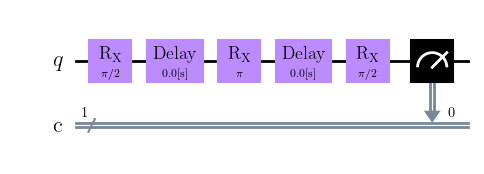

In [463]:
from qiskit_experiments.library.characterization.t2hahn import T2Hahn
qubit = 0
conversion_factor = 1e-6 # our delay will be in micro-sec
delays = list(range(0, 50, 1) )
delays = [float(_) * conversion_factor for _ in delays]
number_of_echoes = 1

# Create a T2Hahn experiment. Print the first circuit as an example
exp1 = T2Hahn(physical_qubits=(qubit,), delays=delays, num_echoes=number_of_echoes)
exp1.circuits()[0].draw('mpl',style='clifford')

This single qubit quantum circuit is a sequence of the following operators:
1. $R_x(\pi/2)$ Rotate qubit about $x$ axis for $\pi/2$ radians. The Bloch vector is rotated onto the $X-Y$ plane and precesses.
2. $N$ echo sequence ($N = 1$ for the Hahn Echo experiment)
    1. $D(t_0)$ Delay for $t = t_0$. Precession happens during this delay, let the final amount be $\Delta\phi_0$. a 
    2. $R_x(\pi)$ Rotate qubit about $x$ axis for $\pi$ radians. The Bloch vector is mirrored about the $X$ axis  
    3. $D(t_0)$ Delay for $t = t_0$ The Bloch vector precesses for amount $\Delta\phi_0$ in an ideal setting, i.e. the Bloch vector sits at where it would be if the initial rotation was $R_x(-\pi/2)$.
3. $R_x(\pi/2)$ Rotate qubit about $x$ axis for $\pi/2$ radians. The Bloch vector completes a $2\pi$ rotation about the $X$ axis. Following the previous stage, ideally, this final rotation brings the Bloch vector to it's initial position.
4. Measurement. In the non-ideal case, the precession during the delay periods would be different, leaving the Bloch vector to deviate from the $Y$ axis. The projection onto the $X-Y$ plane after the final rotation is no longer 0, unlike what is expect of $\ket{0}$.

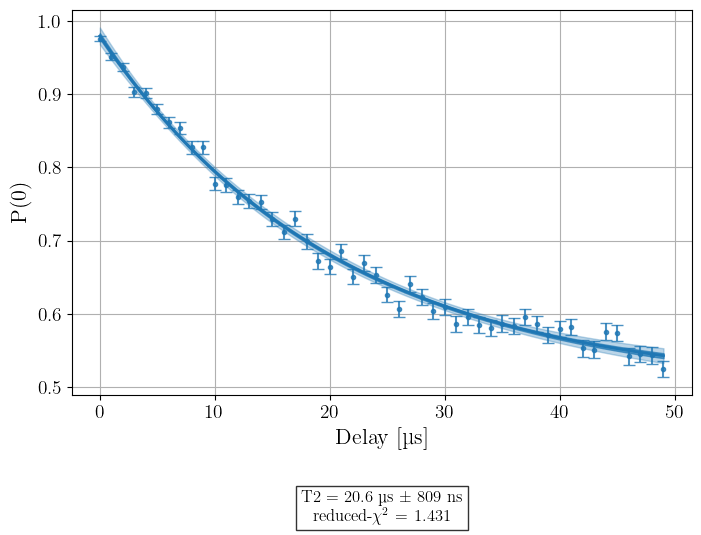

In [464]:
from qiskit_experiments.test.t2hahn_backend import T2HahnBackend

estimated_t2hahn = 20 * conversion_factor
# The behavior of the backend is determined by the following parameters
backend = T2HahnBackend(
    t2hahn=[estimated_t2hahn],
    frequency=[100100],
    initialization_error=[0.0],
    readout0to1=[0.02],
    readout1to0=[0.02],
)
exp1.analysis.set_options(p0=None, plot=True)
expdata1 = exp1.run(backend, shots=2000, seed_simulator=101)
expdata1.block_for_results()  # Wait for job/analysis to finish.

# Display the figure
display(expdata1.figure(0))


## Self implementation of the T2 Hahn Echo experiment

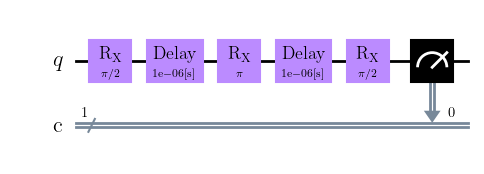

In [341]:
T2_circ = QuantumCircuit(1,1)
T2_circ.rx(np.pi/2,0)
T2_circ.delay(duration=time,qarg=0,unit='s')
T2_circ.rx(np.pi,0)
T2_circ.delay(duration=time,qarg=0,unit='s')
T2_circ.rx(np.pi/2,0)
T2_circ.measure(qubit=0,cbit=0)
T2_circ.draw('mpl',style='clifford')

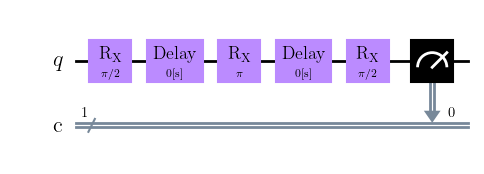

In [441]:
noise_model = NoiseModel()
readout0to1=0.02
readout1to0=0.02
# error = ReadoutError([[1-readout0to1,readout0to1],[readout1to0,1-readout1to0]])
# for more than one qubit, the readout errors must be defined for each one
# ReadoutError([[P(0|0),P(1|0)],[P(0|1),P(1|1)]],\ -> RoE 0th Qubit
#              ...,\
#              [[P(0|0),P(1|0)],[P(0|1),P(1|1)]])  -> RoE (N-1)th Qubit
# noise_model.add_readout_error(error,(0,)) # argument "0" refers to qubit 0
# Attempted to use the backend from the T1 experiment, with the Readout error implemented
# noise_model = NoiseModel.from_backend(FakePerth(), thermal_relaxation=False, gate_error=False, readout_error=False)
# backend = AerSimulator.from_backend(FakePerth(), noise_model=noise_model)
frequency=100100
def T2_delay(time):
    T2_circ = QuantumCircuit(1,1)
    T2_circ.rx(np.pi/2,0)
    # Attempted to substitute "Qubit drift" with a XY plane rotation (incorrect)
    # Assume gate times are negligible, rotation only occur during delay
    # Tried to implement detuning here
    # (this is wrong, since a symmetric precession before and after the pi rotation about x cancels out the effect)
    #angle = 2*np.pi*frequency*time
    #angle = angle%(2*np.pi)
    #T2_circ.rz(angle,0)
    T2_circ.delay(duration=time,qarg=0,unit='s')
    T2_circ.rx(np.pi,0)
    # During the delay, rotate the qubit once again
    #angle = 2*np.pi*frequency*time
    #angle = angle%(2*np.pi)
    #T2_circ.rz(angle,0)
    T2_circ.delay(duration=time,qarg=0,unit='s')
    T2_circ.rx(np.pi/2,0)
    T2_circ.measure(qubit=0,cbit=0)
    return T2_circ
T2_delay(0).draw('mpl',style='clifford')

In [458]:
%%time
trials = 512
T2_results = np.zeros(shape=(len(delays),trials))
# using the same set of delay times
for i, t in enumerate(delays):
    for j in range(trials):
        T2_exe = backend.run(transpile(T2_delay(t),backend=backend),shots=2000)
        # using the same T2HahnBackend
        N0 = T2_exe.result().get_counts()['0'] # P(0)
        N1 = T2_exe.result().get_counts()['1'] # P(1)
        # Discovery on initial run: data has 0 variance
        # Suspect issue in noise_model (and few knowledge on backend/transpile)
        # (readout error, no relaxation error)
        # temporary workaround to include readout error
        # 0 variance without this adjustment
        readout0to1 = np.random.random(size=N0)
        readout1to0 = np.random.random(size=N1)
        N0 = N0 - len(readout0to1[readout0to1<0.02]) + len(readout1to0[readout1to0<0.02])
        T2_results[i,j] = N0/2000
        # P(0) ~ cos(𝜃), the projection to the x-y plane is √(1 - P(0)**2)
        # T2 ~ when sin(𝜃)=1/e. evidently, when P(0) = 0, cos(𝜃) = 0, sin(𝜃) = 1
        
T2_mean = np.mean(T2_results,axis=1)
T2_std = np.std(T2_results,axis=1)

CPU times: user 6min 59s, sys: 1.46 s, total: 7min
Wall time: 4min 12s


In [465]:
print(estimated_t2hahn)
print(T2_results.shape)
#np.save("T2_results_512",T2_results)
delays = np.array(delays)
T2_results = np.load("T2_results_512.npy")
T2_mean = np.mean(T2_results,axis=1)
T2_std = np.std(T2_results,axis=1)
opt_param, param_cov = sp.optimize.curve_fit(T1_prob,delays/us,T2_mean,bounds=([0,0,0],[2,40,1]))
print("Optimal parameters: {:.2f}exp(-t/{:.2f})+{:.2f}".format(opt_param[0],opt_param[1],opt_param[2]))
A = opt_param[0]
T = opt_param[1]
B = opt_param[2]

1.9999999999999998e-05
(50, 512)
Optimal parameters: 0.46exp(-t/9.98)+0.50


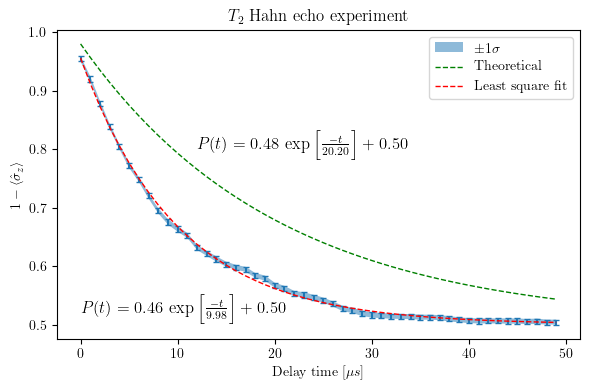

In [467]:
fig = plt.figure(figsize=(6,4))
plt.errorbar(x=delays/us,y=T2_mean,yerr = T2_std,ls='None',capsize=2)
plt.fill_between(delays/us,T2_mean+T2_std,T2_mean-T2_std,alpha=0.5,label=r'$\pm 1\sigma$')
plt.ticklabel_format(axis='x',style='sci',useMathText=True,scilimits=(-3,3))
plt.ylabel(r"$1 - \langle \hat{\sigma}_z \rangle$")
plt.xlabel(r"Delay time $[\mu s]$")
plt.title(r"$T_2$ Hahn echo experiment")
plt.plot(delays/us,T1_prob(delays/us,0.47884,20.205,0.5015),ls='dashed',c='g',lw=1,\
         label='Theoretical')
plt.text(x=12,y=0.8,s=r"$P(t)=%.2f\:\exp\bigg[\frac{-t}{%.2f}\bigg]+%.2f$"%(0.47884,20.205,0.5015),fontsize=12)
plt.plot(delays/us,T1_prob(delays/us,A,T,B),ls='dashed',c='r',lw=1,\
         label='Least square fit')
plt.text(x=0,y=0.52,s=r"$P(t)=%.2f\:\exp\bigg[\frac{-t}{%.2f}\bigg]+%.2f$"%(A,T,B),fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

The discrepancy in the decoherence time is (at the moment) unknown to me.  
Requires further study of the API reference, and `T2Hahn` source code.
> [Reference: T2Hahn(exp)](https://qiskit.org/ecosystem/experiments/dev/manuals/characterization/t2hahn.html)  
> [Reference: T2HahnBackend](https://qiskit.org/ecosystem/experiments/_modules/qiskit_experiments/test/t2hahn_backend.html#T2HahnBackend) 

# T2* Ramsey Characterization
## Introduction
> [Reference: Qiskit documentation](https://qiskit.org/ecosystem/experiments/dev/manuals/characterization/t2ramsey.html)
> 
The purpose of the $T^*_2$ Ramsey experiment is to determine two of the qubit's properties: 
detuning (Ramsey) frequency and $T^*_2$.  
The physical meaning of $T^*_2$ represents the rate of decay towards a mixed state, when the qubit is initially $\ket{1}$.
In this experiment, we will see the effects of relaxation and dephasing on the qubit.

## Sample code

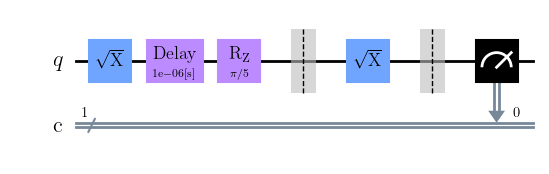

In [548]:
from qiskit_experiments.library import T2Ramsey
qubit = 0
# set the desired delays
delays = list(np.arange(1e-6, 50e-6, 2e-6))

# Create a T2Ramsey experiment. Print the first circuit as an example
exp1 = T2Ramsey((qubit,), delays, osc_freq=1e5)

exp1.circuits()[0].draw('mpl',style='clifford')


The experiment is the a sequence of the following operators:
> [Reference: T2Ramsey source code](https://qiskit.org/ecosystem/experiments/_modules/qiskit_experiments/library/characterization/t2ramsey.html#T2Ramsey)  
* In the demonstrated circuit above, the first operator is the $SX$ gate. Consistent with the source code
    * However, the theoretical overview has the Hadamard gate instead
As a first try, we follow the source code.
1. $SX$ gate
2. $D(t)$ Delay gate
3. $R_z(\pi/5)$ Rotation about $Z$ axis for $\pi/5$
4. Barrier
5. $SX$ gate
6. Measurement     

The explicit expression of the single qubit $SX$ gate in $S_z$ basis:
$$
\sqrt{X} = \frac{1}{2}
\begin{pmatrix}
1+i&1-i\\
1-i&1+i
\end{pmatrix}
$$
In the $S_z$ basis, the Hadamard gate rotates a ket from $\ket{+z}$ to $\ket{-y}$
During the delay, the qubit continues to precess on the $X-Y$ plane.
Before we look at the $Z$ axis rotation, an sanity check in the ideal case where the qubit does not dephase, the $SX$ gate after the delay rotates the qubit to $\ket{-z}$, evidently $\sqrt{X}\sqrt{X} = X$.  
As for the Hadamard gate:
$$
H = \frac{1}{\sqrt{2}}
\begin{pmatrix}
1&1\\
1&-1
\end{pmatrix}
$$
In the $S_z$ basis, the Hadamard gate rotates a ket from $\ket{+z}$ to $\ket{+x}$  
Comparing the transformed $\ket{+Z}$, the difference between two operations is $R_z(\pi/2)$  
The Hadamard gate after the delay will return the qubit to $\ket{+z}$, $HH=I$.  

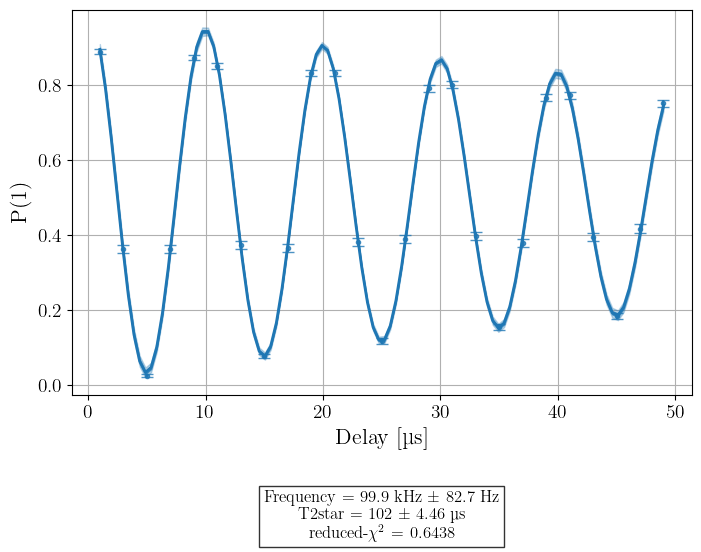

In [495]:
# Create a pure relaxation noise model for AerSimulator
noise_model = NoiseModel.from_backend(
    FakePerth(), thermal_relaxation=True, gate_error=False, readout_error=False
)

# Create a fake backend simulator
backend = AerSimulator.from_backend(FakePerth(), noise_model=noise_model)
# Set scheduling method so circuit is scheduled for delay noise simulation
exp1.set_transpile_options(scheduling_method='asap')

# Run experiment
expdata1 = exp1.run(backend=backend, shots=2000, seed_simulator=101)
expdata1.block_for_results()  # Wait for job/analysis to finish.

# Display the figure
display(expdata1.figure(0))

## Self implementation of the T2* Ramsey experiment

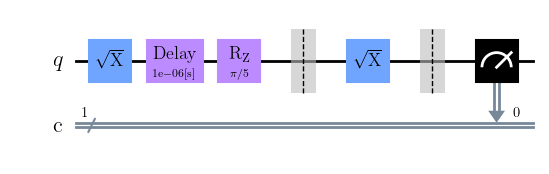

In [496]:
T2r_circ = QuantumCircuit(1,1)
T2r_circ.sx(0)
T2r_circ.delay(duration=time,qarg=0,unit='s')
T2r_circ.rz(np.pi/5,0)
T2r_circ.barrier()
T2r_circ.sx(0)
T2r_circ.barrier()
T2r_circ.measure(qubit=0,cbit=0)
T2r_circ.draw('mpl',style='clifford')

In [553]:
%%time
osc_freq=1e5
def T2r_delay(time):
    T2r_circ = QuantumCircuit(1,1)
    T2r_circ.sx(0)
    T2r_circ.delay(duration=time,qarg=0,unit='s')
    rotation = osc_freq*time*2*np.pi
    T2r_circ.rz(rotation,0)
    T2r_circ.barrier()
    T2r_circ.sx(0)
    T2r_circ.barrier()
    T2r_circ.measure(qubit=0,cbit=0)
    return T2r_circ

# Create a pure relaxation noise model for AerSimulator
noise_model = NoiseModel.from_backend(
    FakePerth(), thermal_relaxation=True, gate_error=False, readout_error=False
)

# Create a fake backend simulator
backend = AerSimulator.from_backend(FakePerth(), noise_model=noise_model)

delays = np.linspace(1e-6, 50e-6, 50)
trials = 512
shots=1024
T2r_results = np.zeros(shape=(len(delays),trials))
for i, t in enumerate(delays):
    for j in range(trials):
        T2r_exe = backend.run(transpile(T2r_delay(t),backend=backend,scheduling_method='asap'))
        T2r_results[i,j] = T2r_exe.result().get_counts()['1']/shots



CPU times: user 2h 11min 3s, sys: 38.1 s, total: 2h 11min 42s
Wall time: 23min 15s


In [554]:
np.save("T2r_results_512",T2r_results)
def T2r_prob(t,a,T2,f,phi,b):
    return a*np.exp(-1*t/T2)*np.cos(2*np.pi*f*t + phi)+b
#T2_results = np.load("T2r_results_1024.npy")
T2r_mean = np.mean(T2r_results,axis=1)
T2r_std = np.std(T2r_results,axis=1)
opt_param, param_cov = sp.optimize.curve_fit(T2r_prob,delays/us,T2r_mean,\
                                             bounds=([0.2,80,80/1000,-np.pi,0.2],[0.8,120,120/1000,np.pi,0.7]))
print("Optimal parameters: {:.2f}exp(-t/{:.2f})cos(2𝜋{:.2f}t+{:.2f})+{:.2f}".format(opt_param[0],opt_param[1],opt_param[2],opt_param[3],opt_param[4]))
a = opt_param[0]
T2 = opt_param[1]
f = opt_param[2]
phi = opt_param[3]
b = opt_param[4]

Optimal parameters: 0.50exp(-t/94.84)cos(2𝜋0.10t+-0.00)+0.50


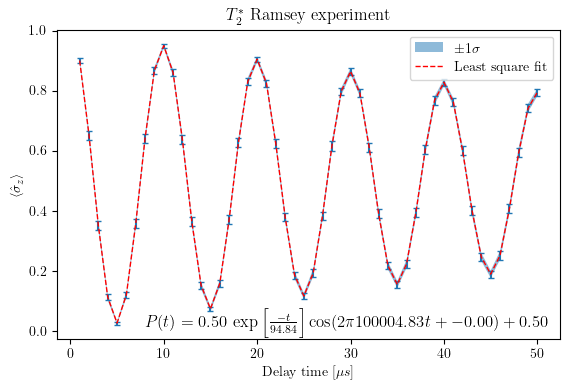

In [572]:
fig = plt.figure(figsize=(6,4))
plt.errorbar(x=delays/us,y=T2r_mean,yerr = T2r_std,ls='None',capsize=2)
#plt.plot(delays/us,T2r_mean,'o')
plt.fill_between(delays/us,T2r_mean+T2r_std,T2r_mean-T2r_std,alpha=0.5,label=r'$\pm 1\sigma$')
plt.ticklabel_format(axis='x',style='sci',useMathText=True,scilimits=(-3,3))
plt.ylabel(r"$\langle \hat{\sigma}_z \rangle$")
plt.xlabel(r"Delay time $[\mu s]$")
plt.title(r"$T_2^*$ Ramsey experiment")
#plt.plot(delays/us,T1_prob(delays/us,0.47884,20.205,0.5015),ls='dashed',c='g',lw=1,\
#         label='Theoretical')
plt.text(x=8,y=0.013,s=r"$P(t)=%.2f\:\exp\bigg[\frac{-t}{%.2f}\bigg]\cos(2\pi{%.2f}t + {%.2f})+%.2f$"%(a,T2,f/us,phi,b),fontsize=12)
plt.plot(delays/us,T2r_prob(delays/us,a,T2,f,phi,b),ls='dashed',c='r',lw=1,\
         label='Least square fit')
plt.legend(loc=1)
plt.tight_layout()
plt.show()